In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/shaz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/shaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shaz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import random
import torch
from transformers import BertTokenizer, BertModel, BertConfig

# Dataset

In [4]:
# load dataset

df_train = pd.read_csv('../Dataset/train.csv')
df_test = pd.read_csv('../Dataset/test.csv')

In [5]:
# training set

df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
# test set (no labels)

df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [9]:
# attributes in the dataset

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


Number of Instances in Each Class:

1    10413
0    10387
Name: label, dtype: int64




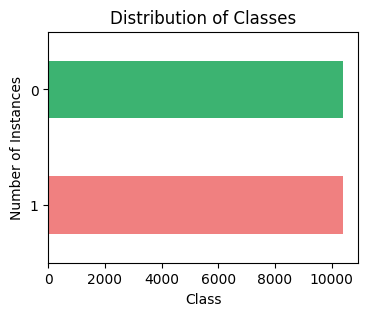

In [13]:
print("Number of Instances in Each Class:\n")
print(df_train['label'].value_counts())
print('\n')

plt.figure(figsize=(4, 3))
df_train['label'].value_counts().plot(kind='barh', color=['lightcoral','mediumseagreen'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

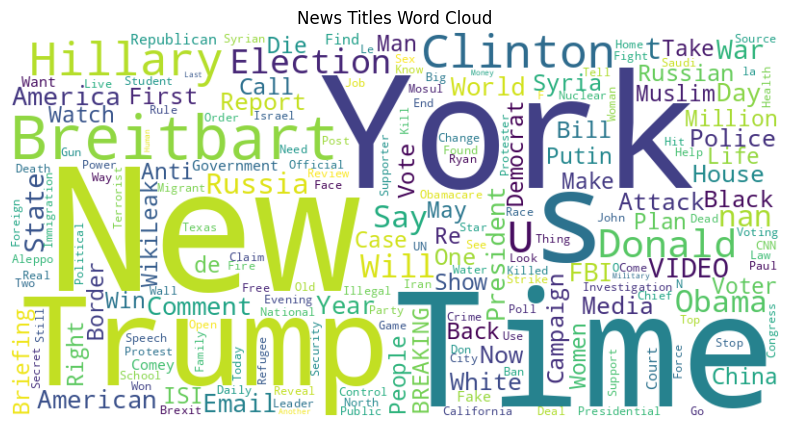

In [ ]:
# Word cloud for titles
from wordcloud import WordCloud

titles_text = ' '.join(df_train['title'].astype(str))

wordcloud = WordCloud(width=800, height=400, collocations = False,
                      max_font_size = 180, background_color='white').generate(titles_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('News Titles Word Cloud')
plt.show()

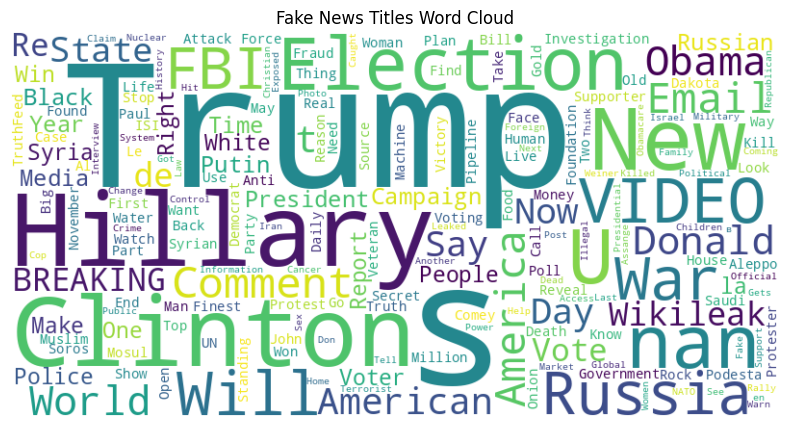

In [11]:
# Word cloud for titles - fake & real

from wordcloud import WordCloud

titles_fake = ' '.join(df_train[df_train['label'] == 1]['title'].astype(str))
titles_real = ' '.join(df_train[df_train['label'] == 0]['title'].astype(str))

wordcloud_fake = WordCloud(width=800, height=400, collocations = False,
                      max_font_size = 180, background_color='white').generate(titles_fake)

wordcloud_real = WordCloud(width=800, height=400, collocations = False,
                      max_font_size = 180, background_color='white').generate(titles_real)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Titles Word Cloud')
plt.show()

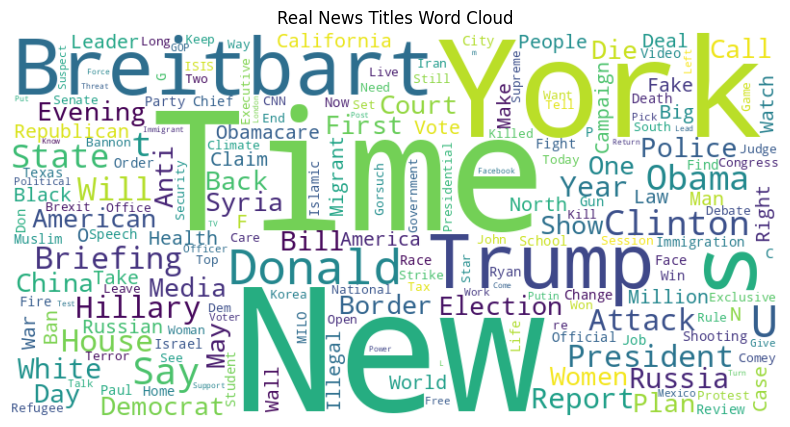

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Real News Titles Word Cloud')
plt.axis('off')
plt.show()

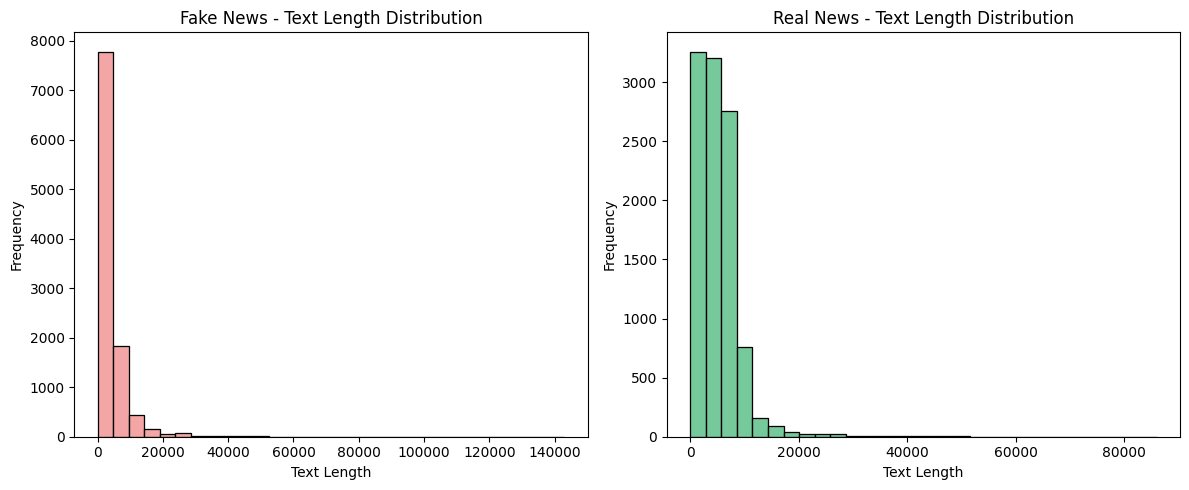

In [15]:
# Histogram of Text Length
plt.figure(figsize=(12, 5))

# Fake News Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_train[df_train['label'] == 1]['text'].astype(str).apply(len), bins=30, color='lightcoral', alpha=0.7)
plt.title('Fake News - Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Real News Histogram
plt.subplot(1, 2, 2)
sns.histplot(df_train[df_train['label'] == 0]['text'].astype(str).apply(len), bins=30, color='mediumseagreen', alpha=0.7)
plt.title('Real News - Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

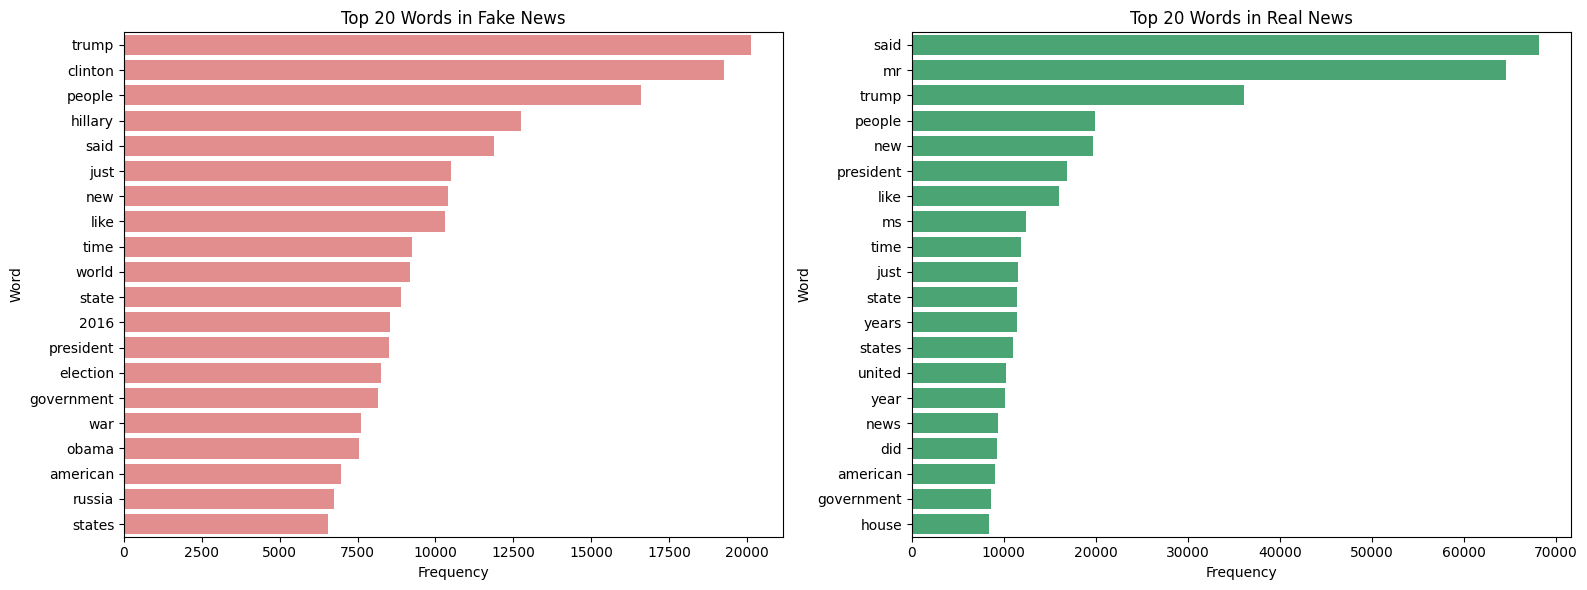

In [ ]:
# Top words in real news and fake news

fake_news = df_train[df_train['label'] == 1]['text']
real_news = df_train[df_train['label'] == 0]['text']

def plot_top_words(data, title, ax, color='blue'):
    cv = CountVectorizer(stop_words='english')
    cv_matrix = cv.fit_transform(data.dropna())

    word_freq = pd.DataFrame(cv_matrix.sum(axis=0), columns=list(cv.get_feature_names_out()))
    word_freq = word_freq.transpose().reset_index()
    word_freq.columns = ['Word', 'Frequency']

    top_words = word_freq.sort_values(by='Frequency', ascending=False).head(20)

    sns.barplot(x='Frequency', y='Word', data=top_words, ax=ax, color=color)
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plot_top_words(fake_news, 'Top 20 Words in Fake News', axs[0], color='lightcoral')
plot_top_words(real_news, 'Top 20 Words in Real News', axs[1], color='mediumseagreen')

plt.tight_layout()
plt.show()

### N gram analysis

In [ ]:
# function to get top n ngrams

def get_top_text_ngrams(corpus, n, ngram):

    vec = CountVectorizer(ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]

In [ ]:
# top bigrams

top_real_bigrams = get_top_text_ngrams(df_train[df_train['label'] == 0].text,n=10,ngram=2)
top_real_bigrams = dict(top_real_bigrams)

top_fake_bigrams = get_top_text_ngrams(df_train[df_train['label'] == 1].text,n=10,ngram=2)
top_fake_bigrams = dict(top_fake_bigrams)

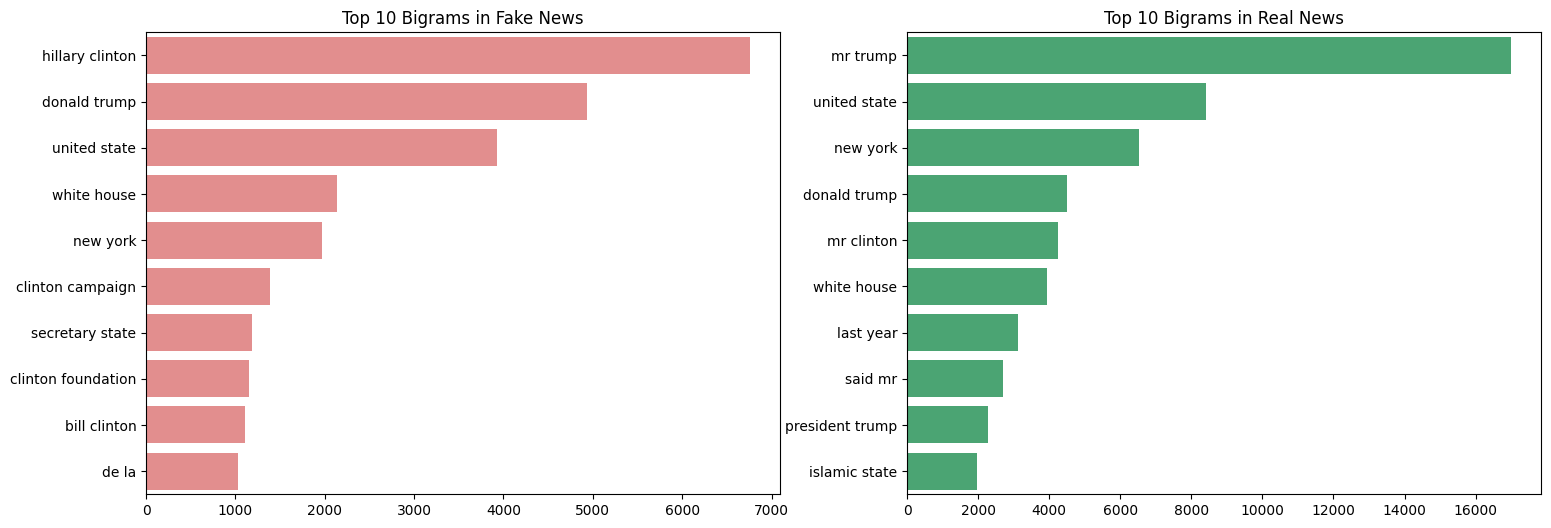

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(x=list(top_fake_bigrams.values()),y=list(top_fake_bigrams.keys()), ax=axs[0], color='lightcoral')
axs[0].set_title('Top 10 Bigrams in Fake News')
sns.barplot(x=list(top_real_bigrams.values()),y=list(top_real_bigrams.keys()), ax=axs[1], color='mediumseagreen')
axs[1].set_title('Top 10 Bigrams in Real News')
plt.show()

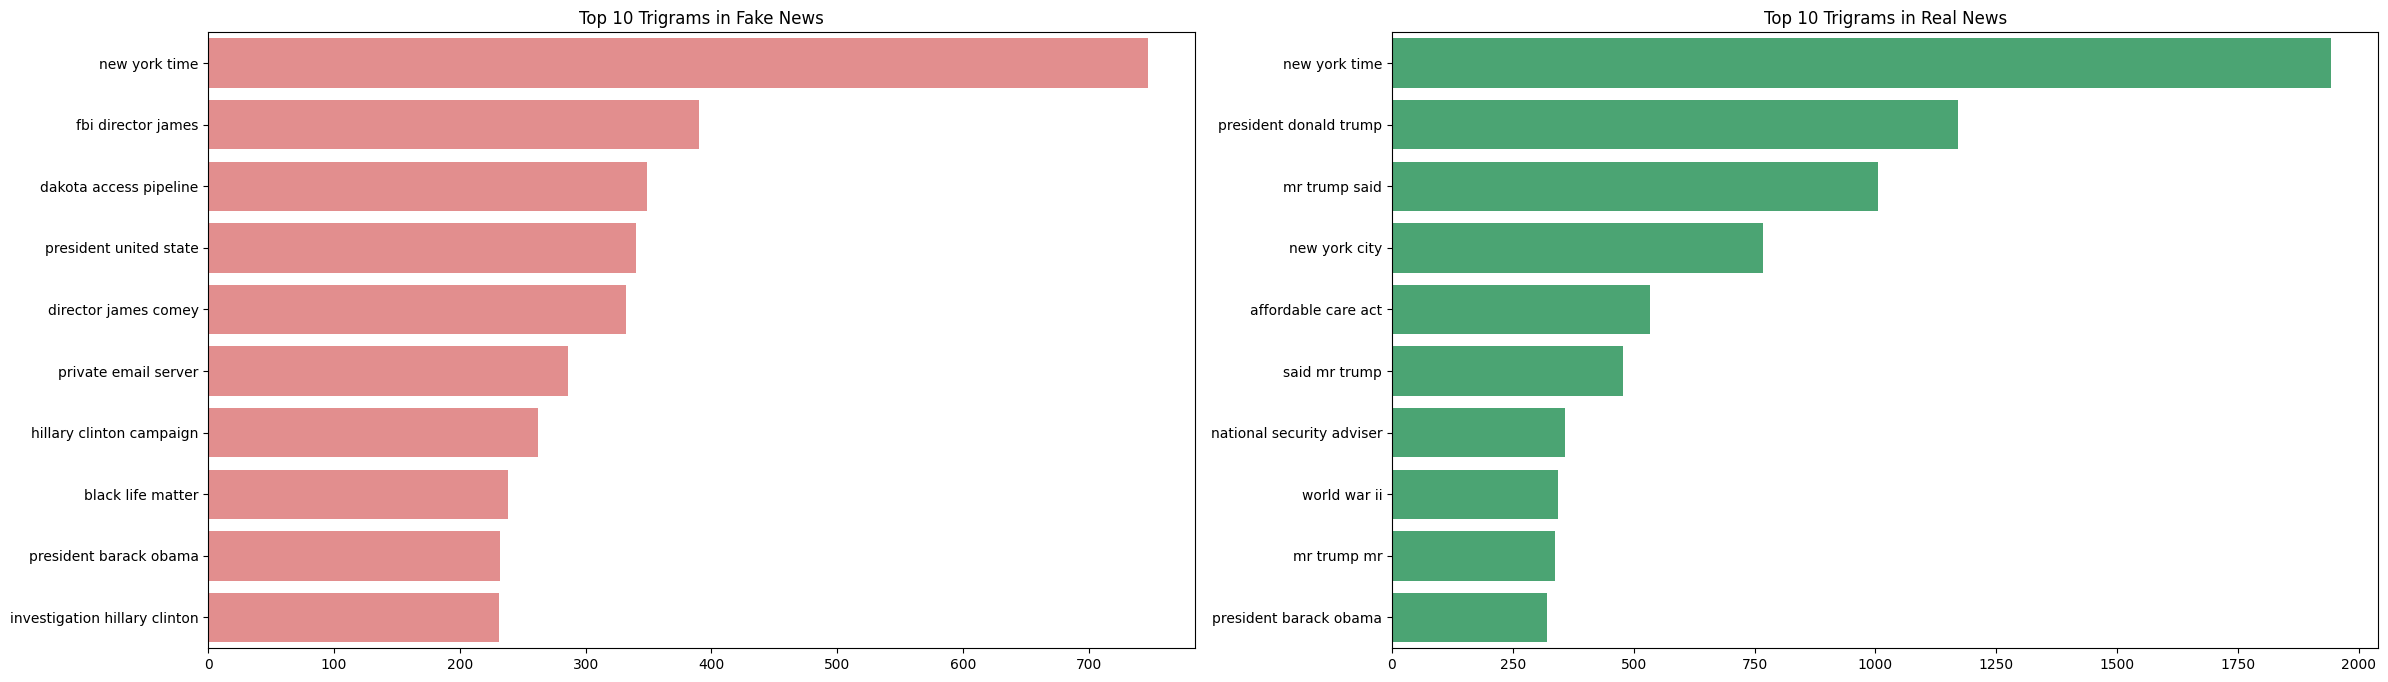

In [ ]:
# top trigrams

top_real_trigrams = get_top_text_ngrams(df_train[df_train['label'] == 0].text,n=10,ngram=3)
top_real_trigrams = dict(top_real_trigrams)

top_fake_trigrams = get_top_text_ngrams(df_train[df_train['label'] == 1].text,n=10,ngram=3)
top_fake_trigrams = dict(top_fake_trigrams)

fig, axs = plt.subplots(1, 2, figsize=(28, 8))
sns.barplot(x=list(top_fake_trigrams.values()),y=list(top_fake_trigrams.keys()), ax=axs[0], color='lightcoral')
axs[0].set_title('Top 10 Trigrams in Fake News')
sns.barplot(x=list(top_real_trigrams.values()),y=list(top_real_trigrams.keys()), ax=axs[1], color='mediumseagreen')
axs[1].set_title('Top 10 Trigrams in Real News')
plt.show()

## Split dataset

In [6]:
# Shuffle the data

np.random.seed(42)

df_train = df_train.sample(frac = 1)
df_train.reset_index(inplace = True)

df_test = df_test.sample(frac = 1)
df_test.reset_index(inplace = True)

In [7]:
# Data Preprocessing

def preprocess_text(text):

    text = text.lower()

    # remove special characters, URLs, and numbers
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)

    # tokenization
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # lemmatization (using WordNet Lemmatizer)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [8]:
df_train['text'] = df_train['text'].astype(str).apply(preprocess_text)
df_train

,index,id,title,author,text,label
0,14649,14649,See Real Voting System Rigged For Election The...,Activist Post,bev harris realtime demo devastating election ...,1
1,9231,9231,"Selected Articles: Trump, the “Alt-right”, and...",NaN,peter koenig november election may rigged prob...,1
2,6473,6473,Donald Trump Says He May Keep Parts of Obama H...,Reed Abelson,day national campaign vowed repeatedly repeal ...,0
3,18736,18736,Nunes ’Unmasking’ Report Vindicates Trump Clai...,Joel B. Pollak,house intelligence committee chair rep devin n...,0
4,12347,12347,Hillary’s Secret Is Out With What Camera Caugh...,Amanda Shea,hillary secret camera caught rally posted nove...,1
...,...,...,...,...,...,...
20795,11284,11284,TRUMP SUPPORTER GOT NUTS On MSNBC Reporter Cov...,EdJenner,go article trump supporter wearing trumppence ...,1
20796,11964,11964,Watch Megyn Kelly almost cry on air when Trump...,Shepard Ambellas,watch megyn kelly almost cry air trump took le...,1
20797,5390,5390,How to Pay for College With Less Stress - The ...,Ron Lieber,quadrennial season financial hope might wish m...,0
20798,860,860,Russian scientists will track sea lions from s...,TASS,russian scientist track sea lion space october...,1


In [9]:
# training and testing sets

X = df_train['text']
y = df_train['label']

# split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("\nTraining Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)


Training Set Shape: (18720,)
Test Set Shape: (2080,)


In [10]:
X_train

7733     say send hillary bengazi let live mr stephen m...
14898    share twitter week tim mcgraw faith hill stopp...
17647    week meet breakfast talk conflicting feeling n...
20232    maria schneider said felt little raped filming...
4742     thursday senate banking housing urban affair c...
                               ...                        
11284    washington federal appeal panel thursday unani...
11964    bob dylan nagging question whether song qualif...
5390     abc post poll released sunday found president ...
860      donald j trump vowed tuesday president would p...
15795    chattanooga tenn jasmine mateen standing outsi...
Name: text, Length: 18720, dtype: object

In [11]:
y_train

7733     1
14898    1
17647    0
20232    0
4742     0
        ..
11284    0
11964    0
5390     0
860      0
15795    0
Name: label, Length: 18720, dtype: int64

# Word Embedding

# GloVe

In [20]:
# load Stanford GloVe model

glove_path = '../GloVe Embedding/glove.6B.100d.txt'

model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)

In [21]:
# GloVe embedding

class GloVeVectorizer:

    def __init__(self, model):
        print("Loading word vectors...")
        self.word_vectors = model
        print("Finished loading word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        # dimensionality of vectors
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        num_samples_no_words = 0

        for n, sentence in enumerate(data):
            tokens = sentence.split()
            vecs = []

            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                num_samples_no_words += 1

        print("Number of samples with no words found: %s / %s" % (num_samples_no_words, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [22]:
vectorizer = GloVeVectorizer(model)

X_train_glove = vectorizer.fit_transform(X_train)

X_test_glove = vectorizer.transform(X_test)

Loading word vectors...
Finished loading word vectors
Number of samples with no words found: 133 / 18720
Number of samples with no words found: 13 / 2080


In [23]:
X_train_glove[0]

array([-0.1606082 ,  0.27368695,  0.25085419, -0.29142302, -0.15009561,
        0.23256838, -0.21479139,  0.0927566 ,  0.0417708 , -0.28539258,
        0.10609001,  0.1843608 ,  0.17300722,  0.12574545, -0.17671451,
       -0.33188343,  0.0183797 ,  0.0588784 , -0.70502597,  0.48719653,
        0.28542972, -0.2179946 ,  0.10911632, -0.21424253,  0.03270321,
        0.1317012 , -0.13410959, -0.40904099,  0.39054111, -0.041375  ,
        0.16636501,  0.56025201,  0.09960081,  0.22592537, -0.0229453 ,
        0.21827698,  0.01951964,  0.187408  ,  0.1373876 , -0.19359967,
       -0.54749507, -0.0839623 ,  0.049329  , -0.3639842 , -0.1747046 ,
       -0.16111115, -0.28852901, -0.24622759, -0.1158309 , -0.68750209,
        0.20053992,  0.01598141,  0.29183659,  0.679838  , -0.12040272,
       -1.86851597, -0.12498653, -0.1095023 ,  0.89574176,  0.0203083 ,
       -0.11863991,  0.60859156, -0.21474472, -0.33592099,  0.66843122,
        0.18925241,  0.39752269,  0.69518965,  0.0146218 , -0.05

In [24]:
with open('../GloVe Embedding/X_train_glove.pkl', 'wb') as file:
    pickle.dump(X_train_glove, file)
    print('Saved Glove Embeddings (X train)')
        
with open('../GloVe Embedding/X_test_glove.pkl', 'wb') as file:
    pickle.dump(X_test_glove, file)
    print('Saved Glove Embeddings (X test)')

Saved Glove Embeddings (X train)
Saved Glove Embeddings (X test)


In [10]:
with open('../GloVe Embedding/X_train_glove.pkl', 'rb') as file:
    X_train_glove = pickle.load(file)
    print('Loaded Glove Embeddings (X train)')
    
with open('../GloVe Embedding/X_test_glove.pkl', 'rb') as file:
    X_test_glove = pickle.load(file)
    print('Loaded Glove Embeddings (X test)')

Loaded Glove Embeddings (X train)
Loaded Glove Embeddings (X test)


## Classification Models with GloVe

In [10]:
# train classifier

def train_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)
    
    print(f"\nAccuracy: {accuracy}")
    print("\nClassification Report:\n")
    print(classification_rep)
    print("\nConfusion Matrix:")
    labels = ['Actual Negative', 'Actual Positive']
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy

### Multinomial Naive Bayes

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_glove_pos = scaler.fit_transform(X_train_glove)
X_test_glove_pos = scaler.transform(X_test_glove)

In [18]:
X_train_glove_pos[0]

array([0.41157359, 0.5550262 , 0.48661786, 0.47473513, 0.55291074,
       0.47752295, 0.37118714, 0.54544705, 0.65388544, 0.23595443,
       0.30732178, 0.59179727, 0.53818814, 0.62544296, 0.21784728,
       0.33757653, 0.5156221 , 0.45597937, 0.31607121, 0.48636779,
       0.55844426, 0.39873192, 0.64068632, 0.32494168, 0.4447838 ,
       0.56197402, 0.41368283, 0.26017986, 0.56122257, 0.41278356,
       0.58021112, 0.48541729, 0.50990882, 0.59268978, 0.39383424,
       0.58028422, 0.55269683, 0.51021901, 0.61025092, 0.38992642,
       0.27468996, 0.48586879, 0.58288915, 0.22696004, 0.40462635,
       0.51218112, 0.44948547, 0.36383398, 0.39307546, 0.30582826,
       0.46572033, 0.3864574 , 0.58858959, 0.63287649, 0.65038397,
       0.2553007 , 0.47895562, 0.27610928, 0.55543931, 0.35016807,
       0.48817109, 0.69970778, 0.51498026, 0.44571275, 0.71517029,
       0.55608128, 0.59724965, 0.55471182, 0.41489908, 0.42626591,
       0.65492165, 0.39749762, 0.39608066, 0.37673529, 0.52458


Accuracy: 0.7038461538461539

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.79      0.72      1030
           1       0.75      0.62      0.68      1050

    accuracy                           0.70      2080
   macro avg       0.71      0.70      0.70      2080
weighted avg       0.71      0.70      0.70      2080


Confusion Matrix:


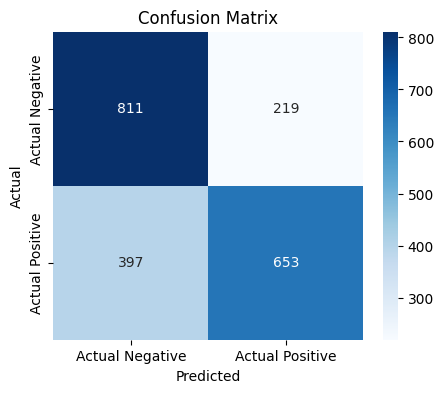

In [19]:
mnb = MultinomialNB()
mnb_acc = train_model(mnb, X_train_glove_pos, y_train, X_test_glove_pos, y_test)

### Decision Tree


Accuracy: 0.7269230769230769

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1030
           1       0.73      0.72      0.73      1050

    accuracy                           0.73      2080
   macro avg       0.73      0.73      0.73      2080
weighted avg       0.73      0.73      0.73      2080


Confusion Matrix:


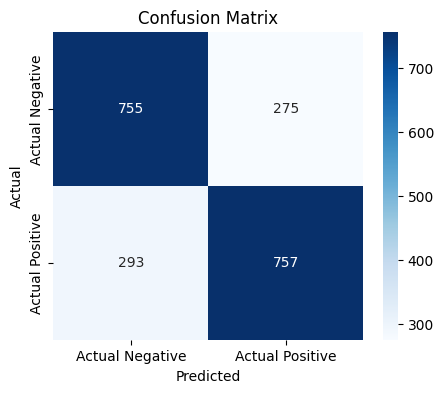

In [49]:
dt = DecisionTreeClassifier()
df_acc = train_model(dt, X_train_glove, y_train, X_test_glove, y_test)

### Random Forest


Accuracy: 0.8480769230769231

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1030
           1       0.85      0.85      0.85      1050

    accuracy                           0.85      2080
   macro avg       0.85      0.85      0.85      2080
weighted avg       0.85      0.85      0.85      2080


Confusion Matrix:


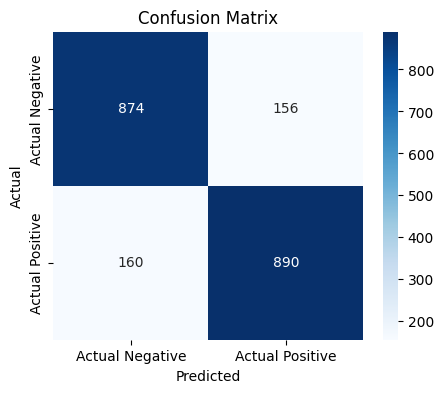

In [50]:
rf = RandomForestClassifier()
rf_acc = train_model(rf, X_train_glove, y_train, X_test_glove, y_test)

### K Nearest Neighbors


Accuracy: 0.8471153846153846

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1030
           1       0.85      0.84      0.85      1050

    accuracy                           0.85      2080
   macro avg       0.85      0.85      0.85      2080
weighted avg       0.85      0.85      0.85      2080


Confusion Matrix:


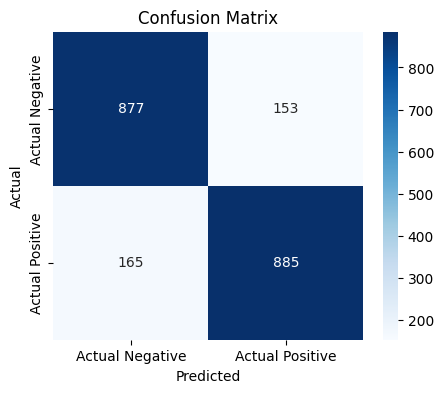

In [51]:
knn = KNeighborsClassifier()
knn_acc = train_model(rf, X_train_glove, y_train, X_test_glove, y_test)

### Classification Results with GloVe

In [11]:
# plot accuracies

def plot_classification_results(accuracy_values, title='Classification results'):
    
    model_names = ['MNB', 'DT', 'RF', 'KNN']
    
    plt.figure(figsize=(7,5))
    plt.bar(model_names, accuracy_values, color='steelblue')

    plt.xlabel('Classification Model')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.title(title)
    plt.grid(False)
    plt.show()

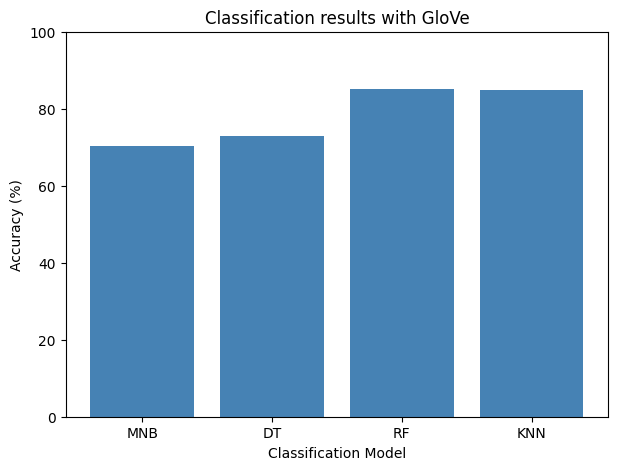

In [25]:
accuracy_values = [mnb_acc,df_acc,rf_acc,knn_acc]
accuracy_values = [item * 100 for item in accuracy_values]

plot_classification_results(accuracy_values, 'Classification results with GloVe')

# BERT

In [13]:
random_seed = 42
random.seed(random_seed)
 
# random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [14]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_base = BertModel.from_pretrained('bert-base-uncased')

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_base = bert_base.to(device)

In [16]:
print('Bert Base\n')
print(f"Number of Layers: {bert_base.config.num_hidden_layers}")
print(f"Hidden Size: {bert_base.config.hidden_size}")
print(f"Attention Heads: {bert_base.config.num_attention_heads}")
print(f"Number of Parameters: {bert_base.num_parameters()}")

Bert Base

Number of Layers: 12
Hidden Size: 768
Attention Heads: 12
Number of Parameters: 109482240


In [48]:
tokenized_data = X.apply(lambda x: tokenizer(x, padding=True, truncation=True, 
                                             add_special_tokens=True, return_tensors='pt'))

In [57]:
with open('../BERT Embedding/tokenized_data.pkl', 'wb') as file:
    pickle.dump(tokenized_data, file)
    print('Saved tokeinzed data')

Saved tokeinzed data


In [17]:
with open('../BERT Embedding/tokenized_data.pkl', 'rb') as file:
    tokenized_data = pickle.load(file)
    print('Loaded tokeinzed data')

Loaded tokeinzed data


In [18]:
embeddings = []

for tokens in tqdm(tokenized_data, desc='Embedding Sentences..'):
    with torch.inference_mode():
        # move input to GPU
        inputs = {key: val.to(device) for key, val in tokens.items()}

        # forward pass
        outputs = bert_base(**inputs)
        word_embeddings = outputs.last_hidden_state

    # move embeddings back to CPU
    sentence_embedding = word_embeddings.mean(dim=1).cpu()
    embeddings.append(sentence_embedding)

Embedding Sentences..: 100%|██████████████| 20800/20800 [10:38<00:00, 32.58it/s]


In [22]:
with open('../BERT Embedding/BERT_Embeddings.pkl', 'wb') as file:
    pickle.dump(embeddings, file)
    print('Saved BERT Embeddings')

Saved BERT Embeddings


In [17]:
with open('../BERT Embedding/BERT_Embeddings.pkl', 'rb') as file:
    tokenized_data = pickle.load(file)
    print('Loaded BERT Embeddings')

Loaded tokeinzed data


In [37]:
X_bert = [embedding.numpy().flatten() for embedding in embeddings]

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y, test_size=0.1, random_state=42)

## Classification Models with GloVe

### Multinomial Naive Bayes

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_bert_pos = scaler.fit_transform(X_train_bert)
X_test_bert_pos = scaler.transform(X_test_bert)


Accuracy: 0.6466346153846154

Classification Report:

              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1030
           1       0.68      0.56      0.62      1050

    accuracy                           0.65      2080
   macro avg       0.65      0.65      0.64      2080
weighted avg       0.65      0.65      0.64      2080


Confusion Matrix:


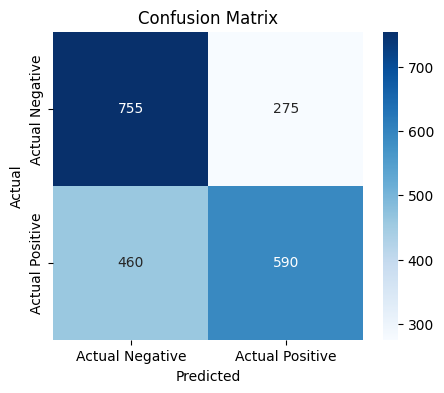

In [41]:
mnb_bert = MultinomialNB()
mnb_bert_acc = train_model(mnb_bert, X_train_bert_pos, y_train_bert, X_test_bert_pos, y_test_bert)

### Decision Tree


Accuracy: 0.7307692307692307

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1030
           1       0.73      0.74      0.73      1050

    accuracy                           0.73      2080
   macro avg       0.73      0.73      0.73      2080
weighted avg       0.73      0.73      0.73      2080


Confusion Matrix:


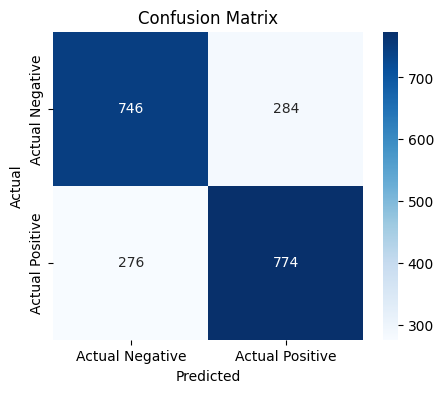

In [42]:
dt_bert = DecisionTreeClassifier()
df_bert_acc = train_model(dt_bert, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

### Random Forest


Accuracy: 0.8495192307692307

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1030
           1       0.86      0.83      0.85      1050

    accuracy                           0.85      2080
   macro avg       0.85      0.85      0.85      2080
weighted avg       0.85      0.85      0.85      2080


Confusion Matrix:


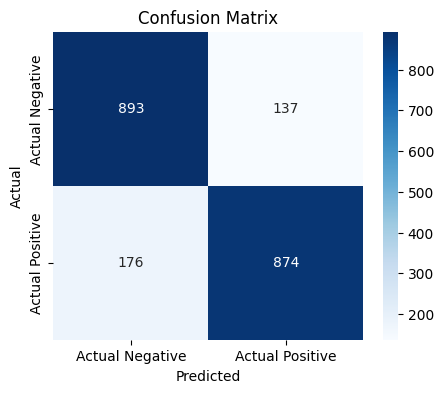

In [46]:
rf_bert = RandomForestClassifier()
rf_bert_acc = train_model(rf_bert, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

### K Nearest Neighbors


Accuracy: 0.8625

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1030
           1       0.88      0.84      0.86      1050

    accuracy                           0.86      2080
   macro avg       0.86      0.86      0.86      2080
weighted avg       0.86      0.86      0.86      2080


Confusion Matrix:


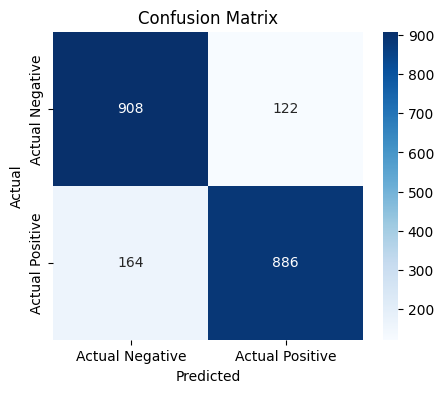

In [47]:
knn_bert = KNeighborsClassifier()
knn_bert_acc = train_model(knn_bert, X_train_bert, y_train_bert, X_test_bert, y_test_bert)

### Classification Results with BERT

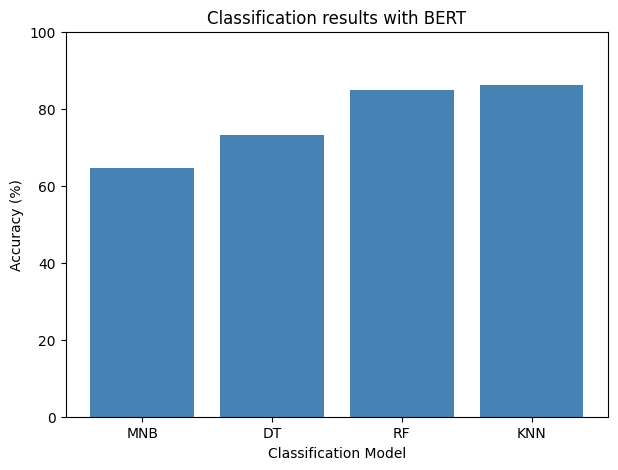

In [51]:
accuracy_values = [mnb_bert_acc,df_bert_acc,rf_bert_acc,knn_bert_acc]
accuracy_values = [item * 100 for item in accuracy_values]

plot_classification_results(accuracy_values, 'Classification results with BERT')